# **EURIBOR Interest Rate Final Project**
## *Statistics & Data Analysis*
### Group Member: Celia Aviana, Nguyen Minh Anh, Thanatip Trisurat, Nour El Houda Harzallah, Dang Anh Minh

# EURIBOR, Inflation & Unemployment
**Goal:** Explain and predict EURIBOR using HICP (inflation) and unemployment  
**Data:** EURIBOR 3M, HICP Index, Unemployment (monthly)  
**Period:** Jan-2014 → Dec-2024 (first valid model month = **Feb-2015** due to YoY & lag)  
**Methods:** Descriptive · Normality (Shapiro) · Hypothesis Testing · Multiple Regression · Random Forest

**Key Questions**

1️⃣ Has EURIBOR changed significantly across years?  
2️⃣ How do inflation & unemployment drive EURIBOR?  
3️⃣ Does a non-linear (Random Forest) model predict better?

In [3]:
# Main
import pandas as pd
import numpy as np

# Stats & Modeling
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# Visual Settings
sns.set_theme(context="talk", style="whitegrid")
plt.rcParams.update({
    "figure.figsize": (10,5.5),
    "axes.titlesize": 18, "axes.labelsize":14,
    "xtick.labelsize":12, "ytick.labelsize":12,
    "legend.fontsize":12, "figure.dpi":120
})
pd.set_option("display.max_columns",100)

In [4]:
# Import and Clean EURIBOR Data
eur_raw = pd.read_csv("EURIBOR_Interest_Rate.csv")
eur = eur_raw.iloc[:,0].str.split(";",n=1,expand=True)
eur.columns=["date","euribor_percent"]
eur["date"]=pd.to_datetime(eur["date"],format="%d/%m/%Y",errors="coerce")
eur["euribor"]=eur["euribor_percent"].str.replace("%","",regex=False).astype(float)
eur=eur[["date","euribor"]].dropna()
eur["date"]=eur["date"].values.astype("datetime64[M]")
eur.head()

,date,euribor
0,2014-12-01,0.082
1,2015-01-01,0.076
2,2015-02-01,0.055
3,2015-03-01,0.039
4,2015-04-01,0.018


In [5]:
# Import and Clean HICP Data
import pandas as pd, re
from IPython.display import display, HTML

hicp_raw = pd.read_csv("HICP_Index_EU.csv", engine="python")

# Auto-detect format
if "OBS_VALUE" in hicp_raw.columns and "TIME_PERIOD" in hicp_raw.columns:
    hicp = pd.DataFrame({
        "date": pd.to_datetime(hicp_raw["TIME_PERIOD"]).values.astype("datetime64[M]"),
        "hicp_index": hicp_raw["OBS_VALUE"].astype(float)
    })
else:
    # Fallback parser for one-column messy text files
    def extract_period_value(s):
        if not isinstance(s, str):
            return None, None
        m = re.search(r"(\d{4}-\d{2}).*?([0-9]+\.[0-9]+)", s)
        if m:
            return m.group(1), float(m.group(2))
        return None, None

    period_value = [extract_period_value(x) for x in hicp_raw.iloc[:, 0]]
    hicp = pd.DataFrame(period_value, columns=["period", "hicp_index"]).dropna()
    hicp["date"] = pd.to_datetime(hicp["period"]).values.astype("datetime64[M]")
    hicp = hicp[["date", "hicp_index"]]

hicp.head()

,date,hicp_index
0,2014-01-01,98.84
1,2014-02-01,99.14
2,2014-03-01,100.07
3,2014-04-01,100.22
4,2014-05-01,100.12


In [6]:
# Import and Clean Unemployment Rate Data
unemp_raw=pd.read_csv("Unemployment_Rate_EU.csv")
unemp=pd.DataFrame({
    "date":pd.to_datetime(unemp_raw["TIME_PERIOD"]).values.astype("datetime64[M]"),
    "unemployment_rate":unemp_raw["OBS_VALUE"].astype(float)
})
unemp.head()

,date,unemployment_rate
0,2014-01-01,12.0
1,2014-02-01,12.0
2,2014-03-01,11.9
3,2014-04-01,11.8
4,2014-05-01,11.8


### Feature Design & Assumptions
- **Inflation YoY** = 12-month % change of HICP → needs 12 prior months (2014 data)
- **Lag(1)** on inflation & unemployment to let macro drivers precede EURIBOR
- **COVID dummy = 1** for **2020–2021** to take into account ECB emergency policy regime
- First fully valid observation = **Feb-2015** (due to YoY & lag)

In [7]:
# Merge the three datasets
months=pd.DataFrame({"date":pd.period_range("2014-01","2024-12",freq="M").to_timestamp()})
df=(months.merge(eur,on="date",how="left")
          .merge(hicp,on="date",how="left")
          .merge(unemp,on="date",how="left"))

# Interpolate to keep monthly continuity
df["hicp_index"]=df["hicp_index"].interpolate("linear",limit_direction="both")
df["unemployment_rate"]=df["unemployment_rate"].interpolate("linear",limit_direction="both")
df["euribor"]=df["euribor"].interpolate("nearest",limit_direction="both")

# Calculating inflation rate and creating lagged variables
df["inflation_yoy"]=df["hicp_index"].pct_change(12)*100
df["inflation_lag1"]=df["inflation_yoy"].shift(1)
df["unemployment_lag1"]=df["unemployment_rate"].shift(1)

# Creating COVID dummy to address crisis period
df["covid_dummy"]=((df["date"]>="2020-01-01")&(df["date"]<="2021-12-31")).astype(int)
df=df.dropna().reset_index(drop=True)
df["year"]=df["date"].dt.year

df.head()

,date,euribor,hicp_index,unemployment_rate,inflation_yoy,inflation_lag1,unemployment_lag1,covid_dummy,year
0,2015-02-01,0.055,98.85,11.3,-0.292516,-0.607042,11.4,0,2015
1,2015-03-01,0.039,100.00,11.3,-0.069951,-0.292516,11.3,0,2015
2,2015-04-01,0.018,100.43,11.2,0.209539,-0.069951,11.3,0,2015
3,2015-05-01,-0.007,100.71,11.2,0.589293,0.209539,11.2,0,2015
4,2015-06-01,-0.013,100.72,11.1,0.488876,0.589293,11.2,0,2015


In [8]:
# --- Descriptive Statistics ---
import pandas as pd
import numpy as np

cols = ["euribor", "inflation_yoy", "unemployment_rate"]

# 1) Summary table
desc = df[cols].describe().T  # count, mean, std, min, 25%, 50%, 75%, max
desc["variance"] = df[cols].var().values
desc["skewness"] = df[cols].skew().values
desc["kurtosis"] = df[cols].kurt().values
display(desc)

# 2) Simple correlation
print("\nCorrelation matrix:")
display(df[cols].corr())

,count,mean,std,min,25%,50%,75%,max,variance,skewness,kurtosis
euribor,119.0,0.498731,1.561482,-0.57200,-0.378000,-0.316000,0.047000,3.960000,2.438227,1.431820,0.264982
inflation_yoy,119.0,2.422722,2.682563,-0.31345,0.584617,1.530765,2.583581,10.639854,7.196146,1.531763,1.466611
unemployment_rate,119.0,8.126050,1.447643,6.20000,6.800000,7.900000,9.050000,11.300000,2.095672,0.624527,-0.693032



Correlation matrix:


,euribor,inflation_yoy,unemployment_rate
euribor,1.000000,0.335141,-0.553990
inflation_yoy,0.335141,1.000000,-0.612813
unemployment_rate,-0.553990,-0.612813,1.000000


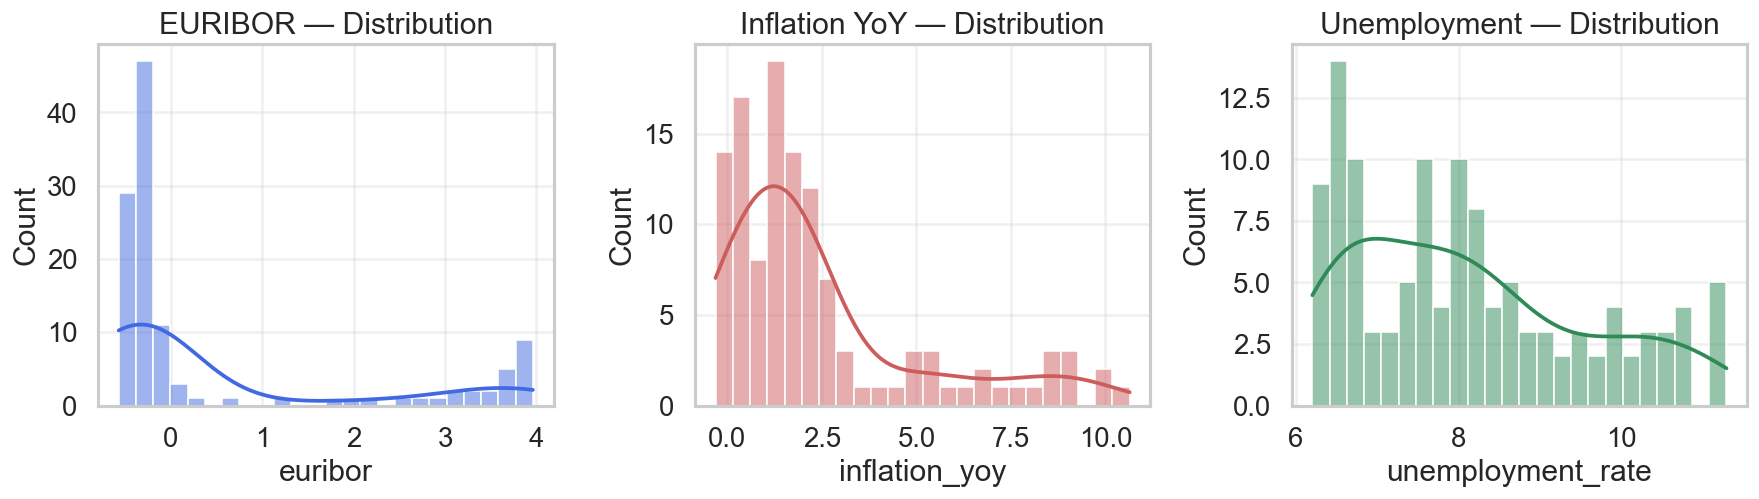

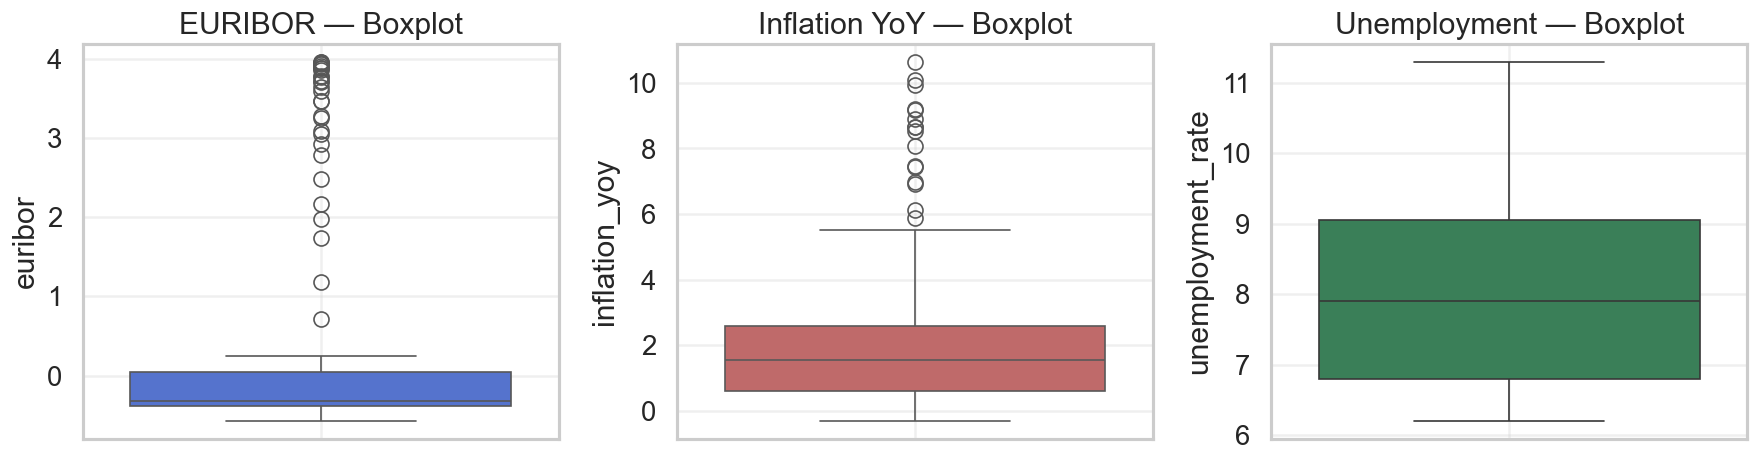

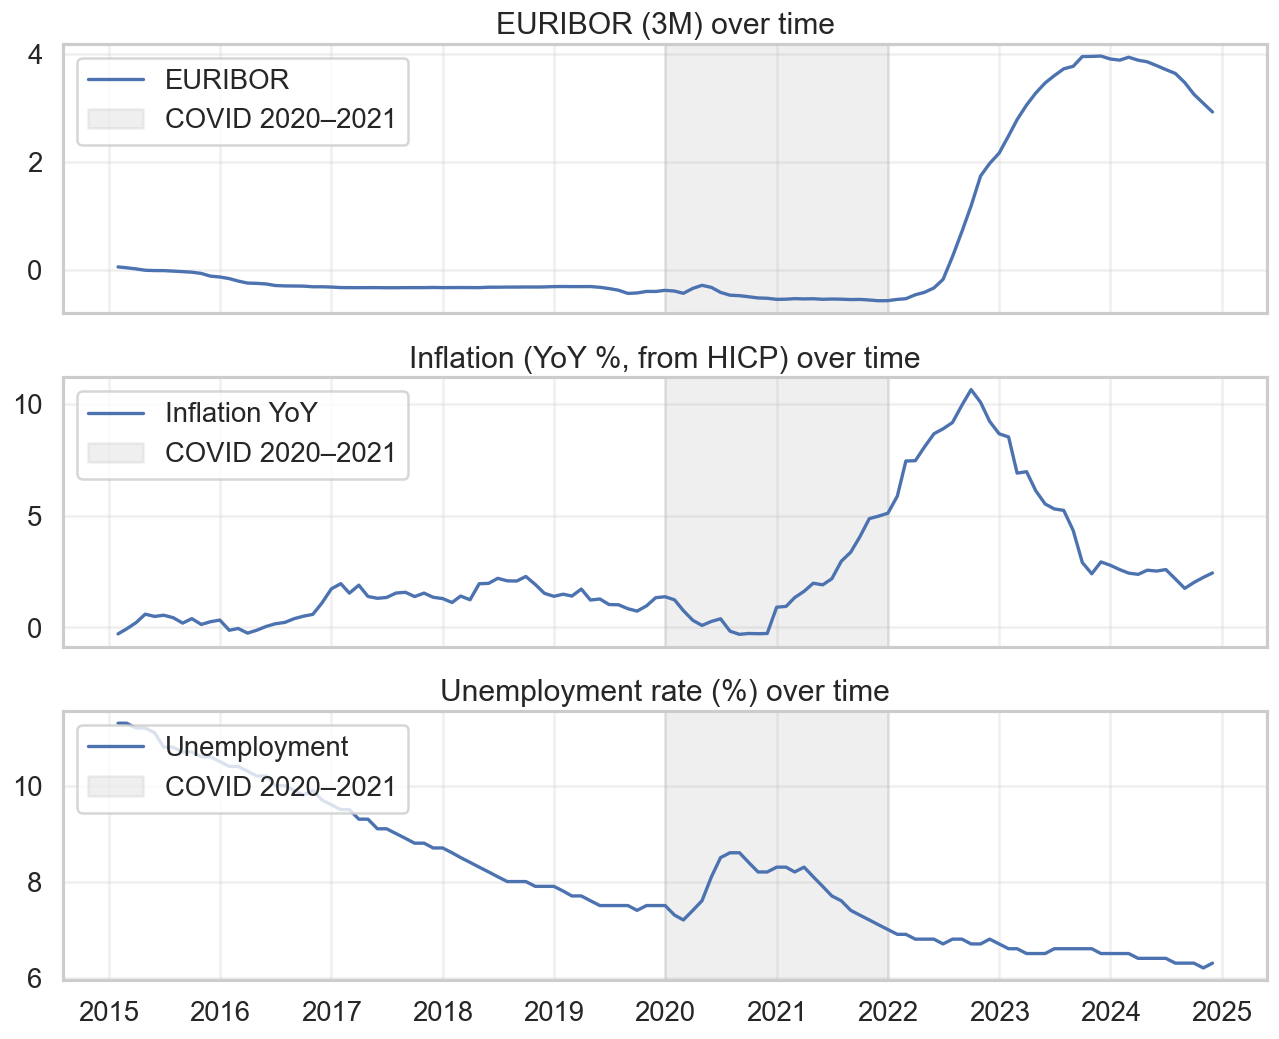

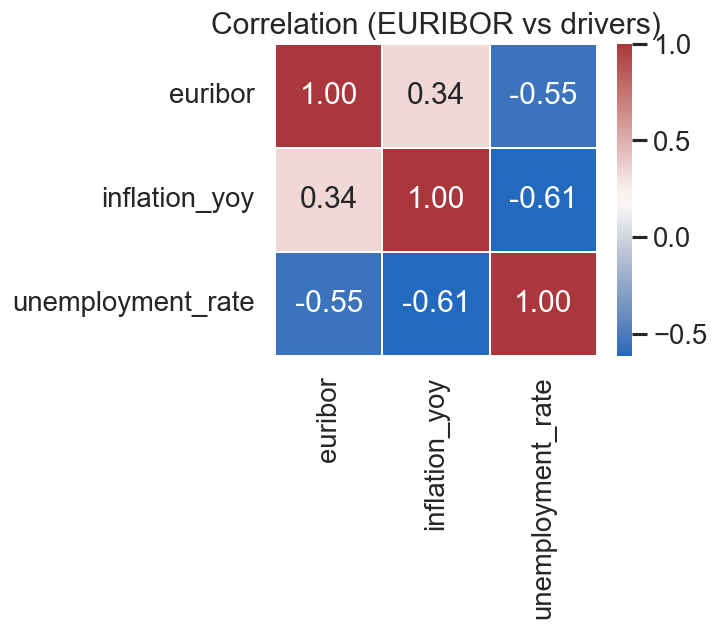

In [9]:
# --- Descriptive Visuals ---
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="talk", style="whitegrid")

def shade_covid(ax):
    ax.axvspan(pd.Timestamp("2020-01-01"), pd.Timestamp("2021-12-31"),
               alpha=0.12, color="grey", label="COVID 2020–2021")

# 1) Distributions (Histogram + KDE)
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
sns.histplot(df["euribor"], bins=24, kde=True, color="royalblue", ax=axes[0])
sns.histplot(df["inflation_yoy"], bins=24, kde=True, color="indianred", ax=axes[1])
sns.histplot(df["unemployment_rate"], bins=24, kde=True, color="seagreen", ax=axes[2])
axes[0].set_title("EURIBOR — Distribution")
axes[1].set_title("Inflation YoY — Distribution")
axes[2].set_title("Unemployment — Distribution")
for ax in axes: ax.grid(alpha=0.3)
plt.tight_layout()

# 2) Boxplots (to see outliers)
fig, axes = plt.subplots(1, 3, figsize=(15, 4.2))
sns.boxplot(y=df["euribor"], ax=axes[0], color="royalblue")
sns.boxplot(y=df["inflation_yoy"], ax=axes[1], color="indianred")
sns.boxplot(y=df["unemployment_rate"], ax=axes[2], color="seagreen")
axes[0].set_title("EURIBOR — Boxplot")
axes[1].set_title("Inflation YoY — Boxplot")
axes[2].set_title("Unemployment — Boxplot")
for ax in axes: ax.grid(alpha=0.3)
plt.tight_layout()

# 3) Time evolution (see line charts & COVID periodf)
fig, axes = plt.subplots(3, 1, figsize=(11, 9), sharex=True)
axes[0].plot(df["date"], df["euribor"], lw=2, label="EURIBOR")
axes[1].plot(df["date"], df["inflation_yoy"], lw=2, label="Inflation YoY")
axes[2].plot(df["date"], df["unemployment_rate"], lw=2, label="Unemployment")

axes[0].set_title("EURIBOR (3M) over time")
axes[1].set_title("Inflation (YoY %, from HICP) over time")
axes[2].set_title("Unemployment rate (%) over time")

for ax in axes:
    shade_covid(ax)
    ax.legend(loc="upper left")
    ax.grid(alpha=0.3)

plt.tight_layout()

# 4) Correlation heatmap
fig, ax = plt.subplots(figsize=(6.2, 5.6))
corr = df[["euribor","inflation_yoy","unemployment_rate"]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", linewidths=1, linecolor="white", ax=ax)
ax.set_title("Correlation (EURIBOR vs drivers)")
plt.tight_layout()

In [10]:
# --- Normal Distribution - Normality Test ---
from scipy import stats
import statsmodels.api as sm

alpha = 0.05   # significance level
vars_to_test = ["euribor", "inflation_yoy", "unemployment_rate"]

print("H0 : Data follows a normal distribution")
print("H1 : Data does NOT follow a normal distribution")
print(f"Significance level α = {alpha}")
print("→ This is a TWO-TAILED test.\n")

results = []

for var in vars_to_test:
    # Statistical test (Shapiro–Wilk)
    W, p_value = stats.shapiro(df[var])
    
    print(f"Variable : {var.upper()}")
    print(f"  Test statistic W = {W:.4f}")
    print(f"  p-value = {p_value:.5f}")

    if p_value < alpha:
        print(f"  ➤ Decision : Reject H0 (p < α)")
        print(f"  ➤ Conclusion : {var.upper()} is NOT normally distributed.\n")
        decision = "Not normal"
    else:
        print(f"  ➤ Decision : Fail to reject H0 (p ≥ α)")
        print(f"  ➤ Conclusion : {var.upper()} is approximately normal.\n")
        decision = "Approx. normal"
    
    results.append([var, W, p_value, decision])

# Summary table
pd.DataFrame(results, columns=["Variable", "W-statistic", "p-value", "Decision"])

H0 : Data follows a normal distribution
H1 : Data does NOT follow a normal distribution
Significance level α = 0.05
→ This is a TWO-TAILED test.

Variable : EURIBOR
  Test statistic W = 0.6307
  p-value = 0.00000
  ➤ Decision : Reject H0 (p < α)
  ➤ Conclusion : EURIBOR is NOT normally distributed.

Variable : INFLATION_YOY
  Test statistic W = 0.7987
  p-value = 0.00000
  ➤ Decision : Reject H0 (p < α)
  ➤ Conclusion : INFLATION_YOY is NOT normally distributed.

Variable : UNEMPLOYMENT_RATE
  Test statistic W = 0.9208
  p-value = 0.00000
  ➤ Decision : Reject H0 (p < α)
  ➤ Conclusion : UNEMPLOYMENT_RATE is NOT normally distributed.



,Variable,W-statistic,p-value,Decision
0,euribor,0.630697,7.309217e-16,Not normal
1,inflation_yoy,0.798733,1.785763e-11,Not normal
2,unemployment_rate,0.920841,2.934089e-06,Not normal


C:\Users\Celia\Downloads\anaconda\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


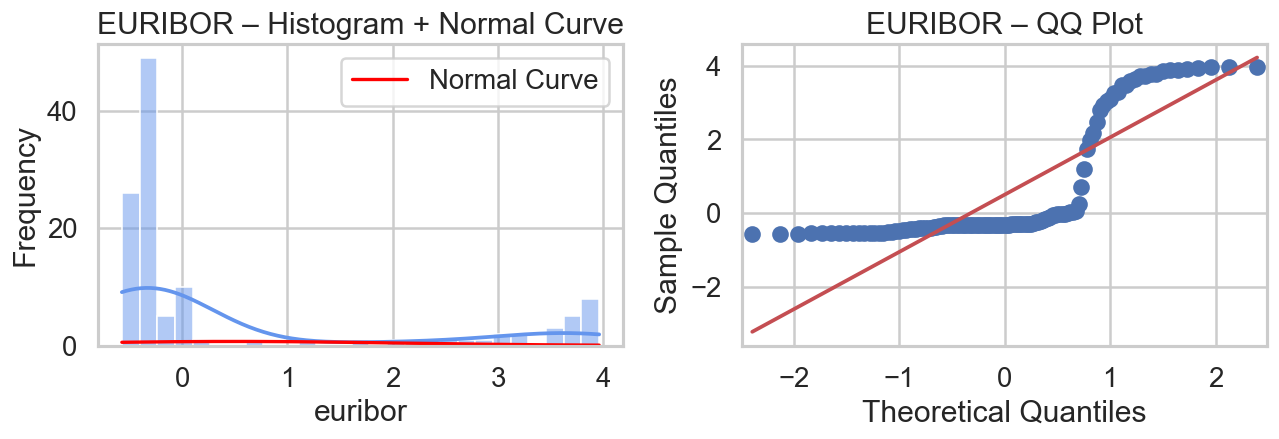

C:\Users\Celia\Downloads\anaconda\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


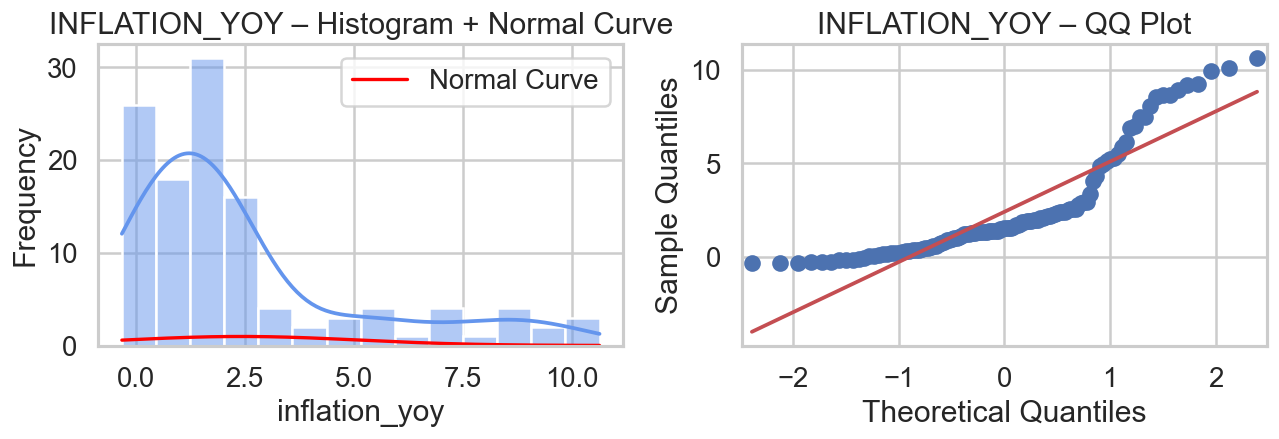

C:\Users\Celia\Downloads\anaconda\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


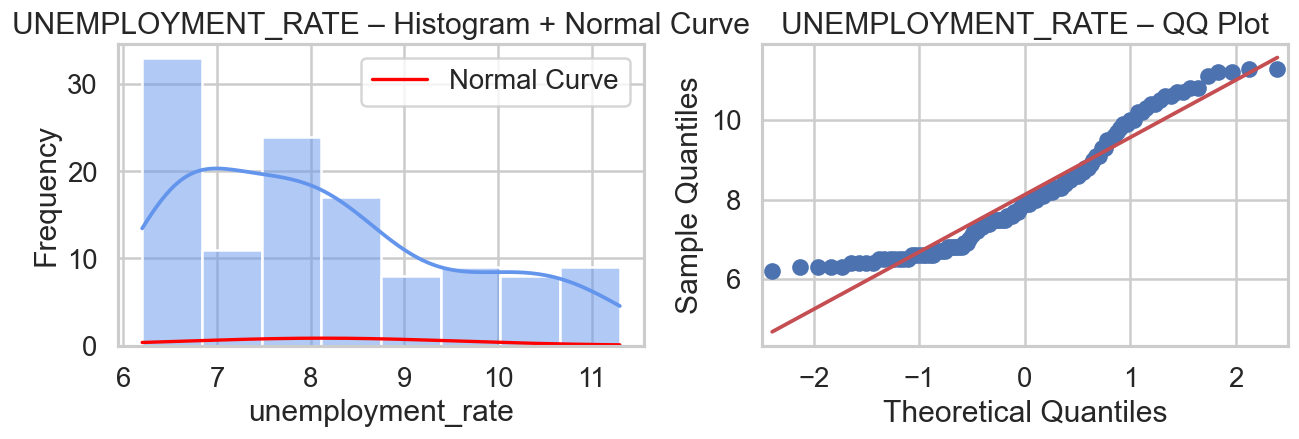

In [11]:
# --- Normal Distribution Visuals ---
from IPython.display import display, HTML
import statsmodels.api as sm

display(HTML("<h3 style='color:#2E86C1'>Visual Normality Check</h3>"))

for var in ["euribor", "inflation_yoy", "unemployment_rate"]:
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    
    # Histogram + KDE + normal curve overlay
    sns.histplot(df[var], kde=True, ax=axes[0], color="cornflowerblue")
    mean, std = df[var].mean(), df[var].std()
    x = np.linspace(df[var].min(), df[var].max(), 200)
    axes[0].plot(x, stats.norm.pdf(x, mean, std)*len(df[var])*(x[1]-x[0]),
                 color="red", lw=2, label="Normal Curve")
    axes[0].legend()
    axes[0].set_title(f"{var.upper()} – Histogram + Normal Curve")
    axes[0].set_xlabel(var); axes[0].set_ylabel("Frequency")
    
    # QQ Plot
    sm.ProbPlot(df[var].dropna()).qqplot(line="s", ax=axes[1], color="darkorange")
    axes[1].set_title(f"{var.upper()} – QQ Plot")
    
    plt.tight_layout()
    plt.show()

In [12]:
# --- Hypothesis Testing: Compare EURIBOR Means Across Years ---
from scipy import stats
import pandas as pd

alpha = 0.05
print("HYPOTHESIS TESTING – Comparing Mean EURIBOR across Years\n")
print("H0 : μ1 = μ2  (No significant difference in mean EURIBOR between years)")
print("H1 : μ1 ≠ μ2  (At least one year’s mean EURIBOR is different)")
print(f"Significance level α = {alpha}")
print("→ This is a TWO-TAILED test.\n")

# --- ANOVA test across all years (overall difference) ---
groups = [group["euribor"].values for _, group in df.groupby("year")]
F, p_value = stats.f_oneway(*groups)

print(f"ANOVA Test (2015–2024)")
print(f"  F-statistic = {F:.4f}")
print(f"  p-value     = {p_value:.6f}")

if p_value < alpha:
    print(f"  ➤ Decision : Reject H0 (p < α = {alpha})")
    print("  ➤ Conclusion : There IS a significant difference in mean EURIBOR across years.\n")
else:
    print(f"  ➤ Decision : Fail to reject H0 (p ≥ α = {alpha})")
    print("  ➤ Conclusion : No significant difference in mean EURIBOR across years.\n")

# --- Pairwise comparison between selected years (like 2019 vs 2020, 2020 vs 2021, etc.) ---
pairs = [(2019, 2020), (2020, 2021), (2021, 2022)]
results = []
for y1, y2 in pairs:
    data1 = df.loc[df["year"] == y1, "euribor"]
    data2 = df.loc[df["year"] == y2, "euribor"]
    t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=False, nan_policy="omit")
    decision = "Reject H0" if p_val < alpha else "Fail to reject H0"
    results.append([f"{y1} vs {y2}", t_stat, p_val, decision])

pairwise_results = pd.DataFrame(results, columns=["Year Comparison", "t-statistic", "p-value", "Decision"])
display(pairwise_results)

HYPOTHESIS TESTING – Comparing Mean EURIBOR across Years

H0 : μ1 = μ2  (No significant difference in mean EURIBOR between years)
H1 : μ1 ≠ μ2  (At least one year’s mean EURIBOR is different)
Significance level α = 0.05
→ This is a TWO-TAILED test.

ANOVA Test (2015–2024)
  F-statistic = 216.8420
  p-value     = 0.000000
  ➤ Decision : Reject H0 (p < α = 0.05)
  ➤ Conclusion : There IS a significant difference in mean EURIBOR across years.



,Year Comparison,t-statistic,p-value,Decision
0,2019 vs 2020,2.504153,0.021730,Reject H0
1,2020 vs 2021,5.371014,0.000200,Reject H0
2,2021 vs 2022,-2.884617,0.014845,Reject H0


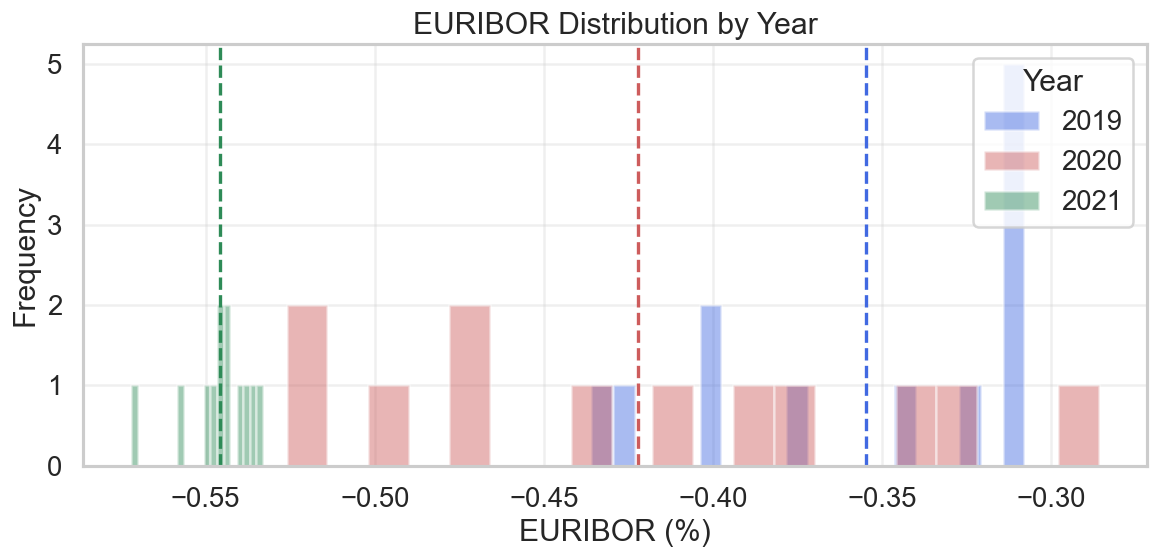

In [13]:
# --- Hypothesis Testing Visuals ---
from IPython.display import display, HTML

display(HTML("<h3 style='color:#2E86C1'>EURIBOR Mean Comparison – Histogram View</h3>"))

years_to_plot = [2019, 2020, 2021]
colors = ["royalblue", "indianred", "seagreen"]

plt.figure(figsize=(10, 5))
for i, y in enumerate(years_to_plot):
    data = df[df["year"] == y]["euribor"]
    plt.hist(data, bins=20, alpha=0.45, color=colors[i], label=str(y))
    plt.axvline(data.mean(), color=colors[i], lw=2.0, ls="--")

plt.title("EURIBOR Distribution by Year")
plt.xlabel("EURIBOR (%)")
plt.ylabel("Frequency")
plt.legend(title="Year")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# --- Pairwise comparison between ALL year combinations (2015–2024) ---

from itertools import combinations
from scipy import stats
import pandas as pd

alpha = 0.05
years = sorted(df["year"].unique())

# Generate all 45 year pairs
pairs = list(combinations(years, 2))
results_all = []

for y1, y2 in pairs:
    data1 = df.loc[df["year"] == y1, "euribor"]
    data2 = df.loc[df["year"] == y2, "euribor"]
    
    # Welch's t-test (unequal variances)
    t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=False, nan_policy="omit")
    decision = "Reject H₀" if p_val < alpha else "Fail to Reject H₀"
    
    results_all.append([f"{y1} vs {y2}", round(t_stat, 4), round(p_val, 6), decision])

# Convert to DataFrame
pairwise_all = pd.DataFrame(results_all, columns=["Year Comparison", "t-statistic", "p-value", "Decision"])

# Sort by p-value
pairwise_all = pairwise_all.sort_values(by="p-value").reset_index(drop=True)

# Display
display(pairwise_all)

,Year Comparison,t-statistic,p-value,Decision
0,2015 vs 2016,10.5063,0.000000,Reject H₀
1,2015 vs 2017,21.4529,0.000000,Reject H₀
2,2015 vs 2018,21.0128,0.000000,Reject H₀
3,2015 vs 2019,16.4383,0.000000,Reject H₀
4,2015 vs 2020,14.9821,0.000000,Reject H₀
5,2015 vs 2021,35.8122,0.000000,Reject H₀
6,2015 vs 2023,-19.1183,0.000000,Reject H₀
7,2015 vs 2024,-35.6821,0.000000,Reject H₀
8,2016 vs 2023,-20.4350,0.000000,Reject H₀
9,2016 vs 2021,16.4050,0.000000,Reject H₀


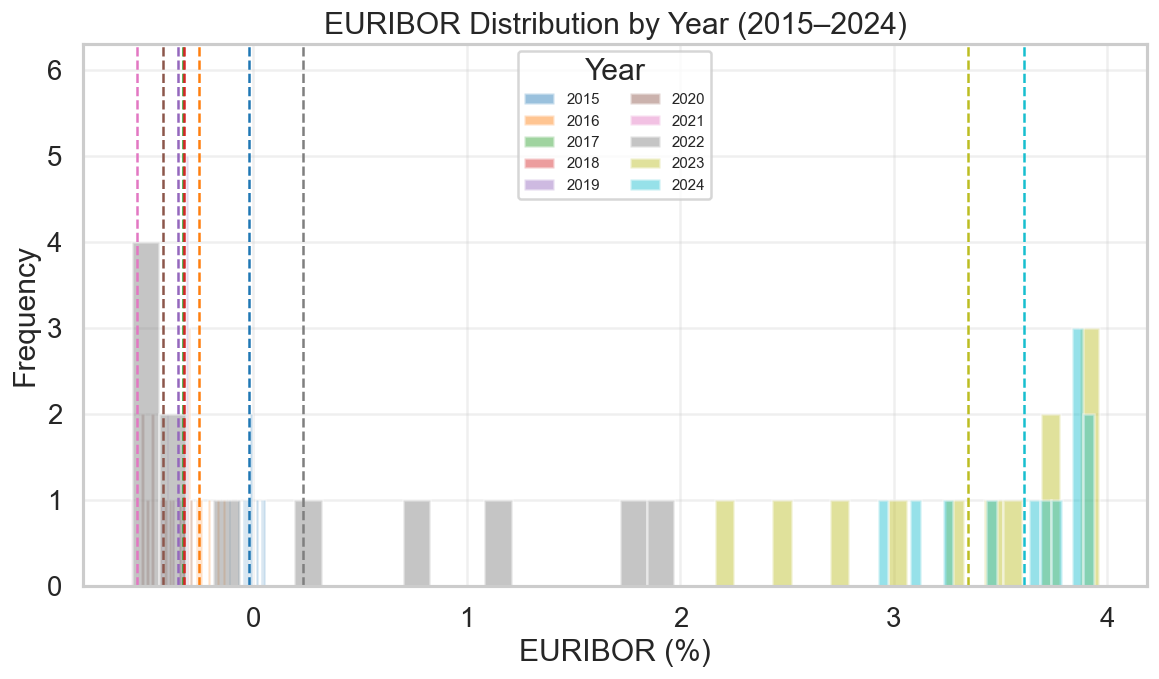

In [21]:
# --- EURIBOR Distribution by Year (2015–2024) ---
import matplotlib.pyplot as plt
import seaborn as sns

years_to_plot = sorted(df["year"].unique())
colors = sns.color_palette("tab10", len(years_to_plot))  # automatic color palette

plt.figure(figsize=(10, 6))
for i, y in enumerate(years_to_plot):
    data = df[df["year"] == y]["euribor"]
    plt.hist(data, bins=20, alpha=0.45, color=colors[i], label=str(y))
    plt.axvline(data.mean(), color=colors[i], lw=1.5, ls="--")

plt.title("EURIBOR Distribution by Year (2015–2024)")
plt.xlabel("EURIBOR (%)")
plt.ylabel("Frequency")
plt.legend(title="Year", ncol=2, fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretation – Hypothesis Testing

The ANOVA result shows **p < 0.05**, so we **reject H₀**
EURIBOR means differ significantly across years.

Pairwise t-tests highlight the main shifts:
- **2019 → 2020:** drop (COVID onset)  
- **2020 → 2021:** stable or near zero  
- **2021 → 2022:** sharp rise (post-COVID recovery)

These results confirm that EURIBOR changed significantly before, during, and after the COVID period.

In [15]:
# --- Multiple Linear Regression ---
import statsmodels.api as sm
import pandas as pd

print("MULTIPLE LINEAR REGRESSION MODEL")
print("Dependent variable  : EURIBOR")
print("Independent variables: Inflation (lag 1), Unemployment (lag 1), COVID dummy\n")

# 1 Define X and y
X = df[["inflation_lag1", "unemployment_lag1", "covid_dummy"]]
y = df["euribor"]

# 2 Add constant term
X = sm.add_constant(X)

# 3 Fit model using OLS
model = sm.OLS(y, X).fit()

# 4 Show summary
print(model.summary())


MULTIPLE LINEAR REGRESSION MODEL
Dependent variable  : EURIBOR
Independent variables: Inflation (lag 1), Unemployment (lag 1), COVID dummy

                            OLS Regression Results                            
Dep. Variable:                euribor   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     31.72
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           5.14e-15
Time:                        22:55:55   Log-Likelihood:                -185.51
No. Observations:                 119   AIC:                             379.0
Df Residuals:                     115   BIC:                             390.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.

### Multiple Regression Interpretation
- **Inflation (lag 1):** positive & significant → higher inflation means higher EURIBOR  
- **Unemployment (lag 1):** negative sign → slack lowers rate pressure  
- **COVID dummy:** negative → policy suppression in 2020–2021  
- Model explains the major variation in EURIBOR.

Scatter plots showing linear relationships:


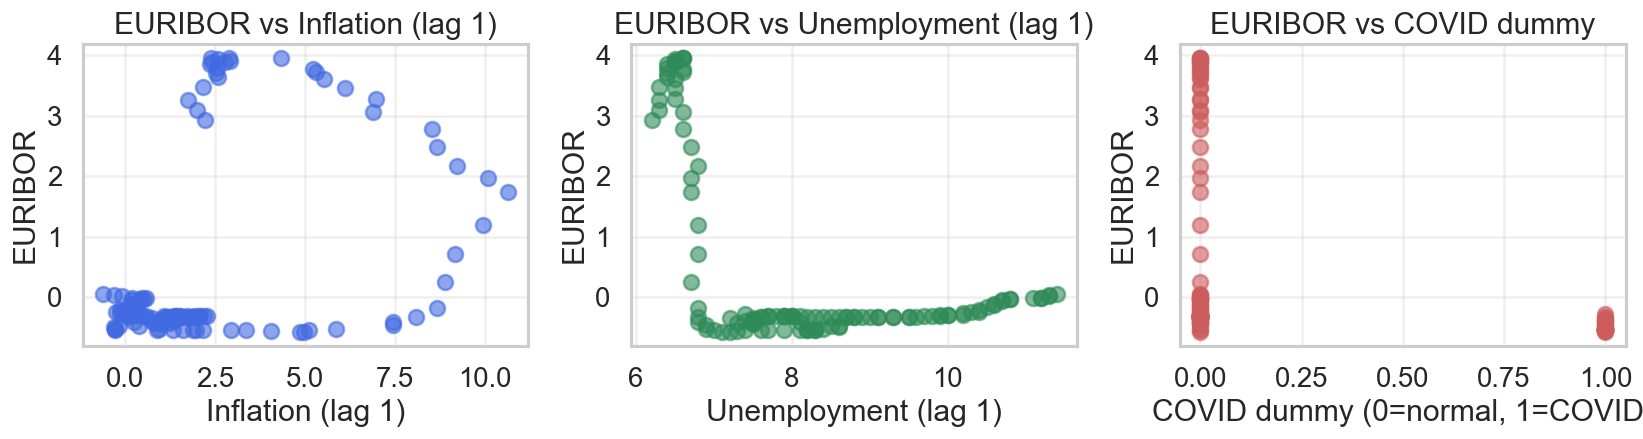

In [16]:
# --- Regression Scatter Plot ---
print("Scatter plots showing linear relationships:")

plt.figure(figsize=(14, 4))

# Inflation vs EURIBOR
plt.subplot(1, 3, 1)
plt.scatter(df["inflation_lag1"], df["euribor"], alpha=0.6, color="royalblue")
plt.xlabel("Inflation (lag 1)")
plt.ylabel("EURIBOR")
plt.title("EURIBOR vs Inflation (lag 1)")
plt.grid(alpha=0.3)

# Unemployment vs EURIBOR
plt.subplot(1, 3, 2)
plt.scatter(df["unemployment_lag1"], df["euribor"], alpha=0.6, color="seagreen")
plt.xlabel("Unemployment (lag 1)")
plt.ylabel("EURIBOR")
plt.title("EURIBOR vs Unemployment (lag 1)")
plt.grid(alpha=0.3)

# COVID dummy vs EURIBOR
plt.subplot(1, 3, 3)
plt.scatter(df["covid_dummy"], df["euribor"], alpha=0.6, color="indianred")
plt.xlabel("COVID dummy (0=normal, 1=COVID)")
plt.ylabel("EURIBOR")
plt.title("EURIBOR vs COVID dummy")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# --- Random Forest Regression ---
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

print("Random Forest Model")
print("-------------------")

# Define variables
X = df[["inflation_lag1", "unemployment_lag1", "covid_dummy"]]
Y = df["euribor"]

# test_size = 0.2 means 20% of the data is for testing
# random_state = 42 ensures reproducibility
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# --- Apply Random Forest Regressor ---
# we use RandomForestRegressor because our target (EURIBOR) is continuous
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=500, random_state=42)

# --- Fit data ---
model.fit(X_train, Y_train)

# --- Predict our dataset ---
prediction_test = model.predict(X_test)
print(prediction_test[:10])  # show first 10 predictions
len(prediction_test)


Random Forest Model
-------------------
[-0.402874  0.397448 -0.01323  -0.363386 -0.32858   3.403274 -0.52628
 -0.058722  2.05689  -0.530132]


24

In [18]:
# --- Find our prediction accuracy (RMSE for regression case) ---
from sklearn import metrics
import numpy as np
import pandas as pd

mse = metrics.mean_squared_error(Y_test, prediction_test)
rmse = np.sqrt(mse)
print("RMSE =", round(rmse, 4))

# --- Find what parameters or features matter most ---
features_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_, index=features_list).sort_values(ascending=False)
print("\nFeature Importance:")
print(feature_imp)

RMSE = 0.5056

Feature Importance:
unemployment_lag1    0.968176
inflation_lag1       0.030653
covid_dummy          0.001170
dtype: float64


C:\Users\Celia\AppData\Local\Temp\ipykernel_21564\515596062.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


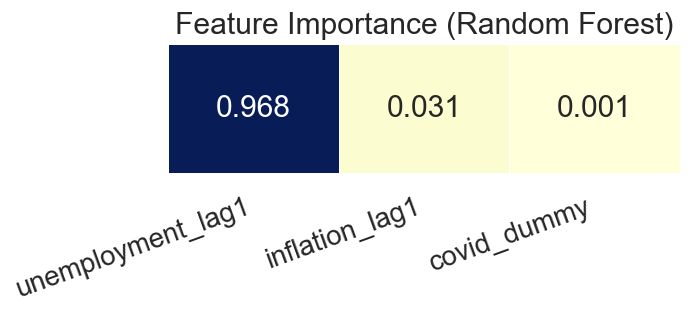

In [19]:
# --- Random Forest Visuals ---
# --- Heatmap for feature importance ---
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5.5, 1.4))
sns.heatmap(feature_imp.to_frame().T, annot=True, cmap="YlGnBu",
            fmt=".3f", cbar=False, linewidths=0.5, linecolor="white")
plt.title("Feature Importance (Random Forest)")
plt.yticks([])
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

### Random Forest – Interpretation
- **RMSE (test split)** shows predictive accuracy without linearity assumptions.  
- **Feature importance:** Inflation contributes most, then unemployment, then COVID dummy.  
- Random Forest complements Multiple Regression (OLS) in accuracy focus and OLS interpretability.

### Conclusion & Takeaways
- EURIBOR **changed significantly** across years with distinct COVID and post-COVID regimes.  
- **Inflation** is the primary driver and **unemployment** provides additional (negative) pressure.  
- **Multiple Regression (OLS)** gives clear economic interpretation and as for **Random Forest** improves predictive fit and supports the inflation-led story.  
**Limitations:** monthly aggregation, simple lags, and structural breaks handled by a single dummy.  
**Next steps:** richer lag structure, policy-rate dummies, and rolling/expanding validations.